In [133]:
#1D DFO Fixed Accuracy
import numpy as np
import scipy.optimize as op
import dfols as dfo
import matplotlib.pyplot as plt

class DFO_FISTA:
    def __init__(self, A, b, y, x0, L, mu, alpha,nu, xi, max_iter=3000, tol=1e-12):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        #self.x0 = np.squeeze(np.asarray(x0))
        self.x0 = np.zeros((np.shape(b)[0],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.L = L
        self.mu = mu
        self.nu = nu
        self.xi = xi
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.upperVal = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.uppersolver = dfo.DFO()
    
    def FISTA(self, alpha,nu,xi,i):
        # Algorithm for solving the lower-level problem
        x = self.x0[i,:]
        t = 0
        if 10*self.uppersolver.delta**2 == 0:
            self.tol = 1e-1
        else:
            self.tol = 1e-2*self.uppersolver.delta**2
        for k in range(self.max_iter):
            x_old = x
            x = x.flatten()
            self.L = 1+ (np.exp(alpha)/np.exp(nu))* 4+np.exp(xi)
            self.mu = 1+np.exp(xi)
            tau = 1/(self.L)
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, alpha, nu, xi,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                self.lowerIterSum += k+1
                return self.x0[i,:]
            x = z -  tau*p

        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        return x
    def DFO(self):
        #solver = dfo.DFO()
        #theta0 = np.array([self.alpha, self.nu, self.xi])
        soln = self.uppersolver.solve(self.UpperLevel, np.array([self.alpha, self.nu, self.xi]),bounds=(-10*np.ones(3),7*np.ones(3)),rhoend=1e-8,print_progress=True,maxfun=300)
        return soln
    def phi(self, x, alpha,nu,xi, i):
        return 0.5*np.linalg.norm(x-self.y[i,:])**2 +np.exp(alpha) * self.TV(x, np.exp(nu)) + 0.5 *np.exp(xi) * np.linalg.norm(x)**2
    def TV(self,x, nu):
        gradx = x[1:]-x[:-1]
        return (np.sum(np.sqrt(np.abs(gradx)**2+ nu**2)))
    def gradTV(self,x, nu):
        grad = np.zeros(len(x))
        grad[:-1]+= -(x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        grad[1:] += (x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)

        #Green 
        # grad[:-1]+= np.tanh(-(x[1:]-x[:-1])/nu)
        # grad[1:] += np.tanh((x[1:]-x[:-1])/nu)
        
        return np.squeeze(np.asarray(grad))
    def gradPhi(self, x, alpha,nu,xi,i):
        return np.squeeze(np.asarray(x - np.squeeze(np.asarray(self.y[i,:])) + np.exp(alpha) *self.gradTV(x, np.exp(nu)) + np.exp(xi) * x))
    
    def UpperLevel(self,theta):
        alpha = theta[0]
        nu = theta[1]
        xi = theta[2]
        # FISTA
        if 1:
            UL = []
            for i in range(np.shape(self.b)[0]):
                UL.append(np.sqrt(1/np.shape(self.b)[0])*np.linalg.norm(self.FISTA(alpha,nu,xi,i)- np.squeeze(np.asarray(self.b[i,:].flatten()))))
            UL.append(np.exp(xi))
            # self.upperVal.append(np.sum(UL))
            # self.lowerIter.append(self.lowerIterSum)
            if self.uppersolver.funVal==0 or self.uppersolver.funVal==None:
                Usquared = [r**2 for r in UL]
                self.upperVal.append(np.sum(Usquared))
                self.lowerIter.append(self.lowerIterSum)
            if self.uppersolver.funVal!=0:
                self.upperVal.append(self.uppersolver.funVal)
                self.lowerIter.append(self.lowerIterSum)
        return np.squeeze(np.array([UL]))
    def LBFGS(self,alpha,nu,xi,i):
        # op.fmin_l_bfgs_b(self.phi, self.gradPhi, x0=self.x0, args=(i,theta))
        self.x0 = op.minimize(self.phi, self.x0, args=(alpha,nu,xi,i), method='L-BFGS-B', jac=self.gradPhi,tol=1e-14).x
        return np.squeeze(np.asarray(self.x0))


Initialise DFO
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1    8.90e-01  3.57e-01  3.00e-01  3.00e-01    4   
  1     2    8.90e-01  1.38e+00  1.50e-01  3.00e-02    5   
  1     3    8.90e-01  2.18e+00  7.50e-02  3.00e-02    6   
  1     4    8.81e-01  5.63e-01  3.00e-02  3.00e-02    8   
  1     5    8.51e-01  7.78e-01  1.20e-01  3.00e-02    9   
  1     6    7.72e-01  6.69e-01  4.80e-01  3.00e-02   10   
  1     7    5.89e-01  4.18e-01  4.80e-01  3.00e-02   11   
  1     8    5.09e-01  1.56e+00  4.80e-01  3.00e-02   12   
  1     9    4.76e-01  3.65e-01  2.40e-01  3.00e-02   14   
  1    10    4.28e-01  3.37e-01  2.40e-01  3.00e-02   15   
  1    11    4.14e-01  3.59e-01  2.40e-01  3.00e-02   16   
  1    12    3.76e-01  2.02e-01  2.40e-01  3.00e-02   17   
  1    13    3.36e-01  1.85e-01  9.60e-01  3.00e-02   18   
  1    14    2.56e-01  2.04e-01  9.60e-01  3.00e-02   19   
  1    15    2.21e-01  2.74e-01  9.60e-01  3.00e-02   20   
  1    16    2.21e-01  9.

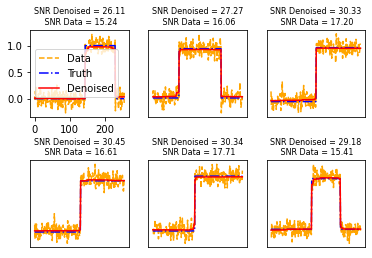

In [134]:
#Denoising 1D
from cProfile import label
from turtle import color


x0 = np.random.rand(1,256)
data = np.load('1dData.npz')
b = data['X']
b = b[:100,:]
A = np.eye(x0.shape[1])
y = data['y']
y = y[:100,:]
#theta = [nu, xi, alpha] = [1e-3,1e-3,1e-3]
Bilevel = DFO_FISTA(A, b, y, x0, 1, 1.3, -1, -3, -3)

result = Bilevel.DFO()
thetaOptimal = result.x
print(thetaOptimal)
#thetaOptimal = [-0.16886349, -8.55251328, -6.96949068]

denoised = Bilevel.FISTA(thetaOptimal[0],thetaOptimal[1],thetaOptimal[2],1)
# plt.plot(b[1,:])
# plt.plot(denoised)
# plt.show()

# plt.plot(Bilevel.lowerIter,Bilevel.upperVal,color='magenta')
# plt.xlabel('Lower Level Iteration')
# plt.ylabel('Upper Level Objective Value')
# plt.xscale('log')
# plt.yscale('log')
snr = 10*np.log10(np.linalg.norm(b[1,:])**2/np.linalg.norm(b[1,:]-denoised)**2)
Nsnr = 10*np.log10(np.linalg.norm(b[1,:])**2/np.linalg.norm(b[1,:]-y[1,:])**2)
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6))= plt.subplots(2, 3)
ax1.plot(y[1,:],label='Data',linestyle='--',color = 'orange')
ax1.plot(b[1,:],label='Truth',linestyle = '-.',color = 'blue')
ax1.plot(denoised,label='Denoised',color = 'red')
# ax1.axes.get_xaxis().set_visible(False)
# ax1.axes.get_yaxis().set_ticks([])
ax1.legend()
ax1.set_title('SNR Denoised = '+"{:.2f}".format(snr) +"\n SNR Data = "+"{:.2f}".format(Nsnr) ,fontsize=8)

denoised = Bilevel.FISTA(thetaOptimal[0],thetaOptimal[1],thetaOptimal[2],3)
snr = 10*np.log10(np.linalg.norm(b[3,:])**2/np.linalg.norm(b[3,:]-denoised)**2)
Nsnr = 10*np.log10(np.linalg.norm(b[3,:])**2/np.linalg.norm(b[3,:]-y[3,:])**2)

ax2.plot(y[3,:],label='Data',linestyle='--',color = 'orange')
ax2.plot(b[3,:],label='Truth',linestyle='-.',color = 'blue')
ax2.plot(denoised,label='Denoised',color = 'red')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_ticks([])
ax2.set_title('SNR Denoised = '+"{:.2f}".format(snr) +"\n SNR Data = "+"{:.2f}".format(Nsnr) ,fontsize=8)

denoised = Bilevel.FISTA(thetaOptimal[0],thetaOptimal[1],thetaOptimal[2],5)
Nsnr = 10*np.log10(np.linalg.norm(b[5,:])**2/np.linalg.norm(b[5,:]-y[5,:])**2)
snr = 10*np.log10(np.linalg.norm(b[5,:])**2/np.linalg.norm(b[5,:]-denoised)**2)
ax3.plot(y[5,:],label='Data',linestyle='--',color = 'orange')
ax3.plot(b[5,:],label='Truth',linestyle='-.',color = 'blue')
ax3.plot(denoised,label='Denoised',color = 'red')
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_ticks([])
ax3.set_title('SNR Denoised = '+"{:.2f}".format(snr) +"\n SNR Data = "+"{:.2f}".format(Nsnr) ,fontsize=8)

denoised = Bilevel.FISTA(thetaOptimal[0],thetaOptimal[1],thetaOptimal[2],7)
snr = 10*np.log10(np.linalg.norm(b[7,:])**2/np.linalg.norm(b[7,:]-denoised)**2)
Nsnr = 10*np.log10(np.linalg.norm(b[7,:])**2/np.linalg.norm(b[7,:]-y[7,:])**2)
ax4.plot(y[7,:],label='Data',linestyle='--',color = 'orange')
ax4.plot(b[7,:],label='Truth',linestyle='-.',color = 'blue')
ax4.plot(denoised,label='Denoised',color = 'red')
ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_ticks([])
ax4.set_title('SNR Denoised = '+"{:.2f}".format(snr) +"\n SNR Data = "+"{:.2f}".format(Nsnr) ,fontsize=8)

denoised = Bilevel.FISTA(thetaOptimal[0],thetaOptimal[1],thetaOptimal[2],10)
snr = 10*np.log10(np.linalg.norm(b[10,:])**2/np.linalg.norm(b[10,:]-denoised)**2)
Nsnr = 10*np.log10(np.linalg.norm(b[10,:])**2/np.linalg.norm(b[10,:]-y[10,:])**2)
ax5.plot(y[10,:],label='Data',linestyle='--',color = 'orange')
ax5.plot(b[10,:],label='Truth',linestyle='-.',color = 'blue')
ax5.plot(denoised,label='Denoised',color = 'red')
ax5.axes.get_xaxis().set_visible(False)
ax5.axes.get_yaxis().set_ticks([])
ax5.set_title('SNR Denoised = '+"{:.2f}".format(snr) +"\n SNR Data = "+"{:.2f}".format(Nsnr) ,fontsize=8)

denoised = Bilevel.FISTA(thetaOptimal[0],thetaOptimal[1],thetaOptimal[2],13)
snr = 10*np.log10(np.linalg.norm(b[13,:])**2/np.linalg.norm(b[13,:]-denoised)**2)
Nsnr = 10*np.log10(np.linalg.norm(b[13,:])**2/np.linalg.norm(b[13,:]-y[13,:])**2)
ax6.plot(y[13,:],label='Data',linestyle='--',color = 'orange')
ax6.plot(b[13,:],label='Truth',linestyle='-.',color = 'blue')
ax6.plot(denoised,label='Denoised',color = 'red')
ax6.axes.get_xaxis().set_visible(False)
ax6.axes.get_yaxis().set_ticks([])
ax6.set_title('SNR Denoised = '+"{:.2f}".format(snr) +"\n SNR Data = "+"{:.2f}".format(Nsnr) ,fontsize=8)
plt.subplots_adjust(hspace=0.5)
fig.savefig('1d dynamic SNR.png',dpi=300)


In [137]:
#Renaming images
import os
path = '/Users/sadegh/Downloads/Humans/'
files = os.listdir(path)


for index, file in enumerate(files):
    os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(index), '.jpg'])))

In [ ]:
#Croping images
from PIL import Image
path = '/Users/sadegh/Downloads/Humans/'
new_width = 512
new_height = 512
for i in range(188):
    im = Image.open(path + '/' + str(i) + '.jpg')
    width, height = im.size   # Get dimensions

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    im.save(path+ '/croped' + '/' + str(i) + '.png', 'PNG')

In [57]:
#Gray scaling & Resizing images
from PIL import Image
path = '/Users/sadegh/Downloads/Humans'

for i in range(300):
    im = Image.open(path + '/' + str(i) + '.jpg')
    im = im.convert('L')
    im = im.resize((256,256))
    im.save(path+ '/256*256' + '/' + str(i) + '.png', 'PNG')

    

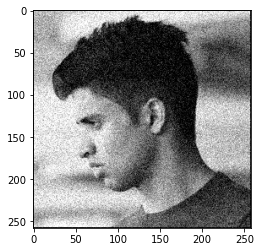

In [64]:
# Making a dataset 2D images
import matplotlib.pyplot as plt
import numpy as np
path = '/Users/sadegh/Downloads/Humans/256*256'

X = np.zeros((300,66564))
extended = np.zeros((258,258))
for i in range(300):
    im = Image.open(path + '/' + str(i) + '.png')
    data = np.asarray(im)
    extended[1:-1,1:-1] = data
    data = np.array(extended.flatten())
    #print(np.shape(data))
    X[i,:] = data

#print(np.shape(X))
np.savez(path+ '/' +'Data.npz', X=X)

data = np.load(path+ '/' +'Data.npz')
X = data['X']
X= X/255

for i in range(1,X.shape[0]-1):
    for j in range(1,X.shape[1]-1):
        Noise = np.random.normal(0,0.1,1)
        #noise = np.random.normal(0, 0.1, 1)
        if X[i,j] + Noise > 1:
            X[i,j] = 1
        elif X[i,j] + Noise < 0:
            X[i,j] = 0
        else:
            X[i,j] = X[i,j] + Noise
Noisy = X*255

np.savez(path+ '/' +'DataNoisy2.npz', y=Noisy)
sample= Noisy[10,:]
sample = sample.reshape(258,258)
sample = Image.fromarray(sample)
plt.imshow(sample)
plt.show()




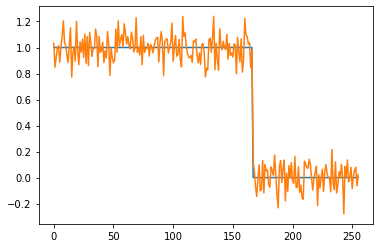

In [163]:
#1D image generating
N = 256
X = np.zeros((100,N))
for i in range(100):
    c = N/4 +np.random.rand(1)*3*N/4
    r = N/8 +np.random.rand(1)*N/4
    for j in range(N):
        if np.abs(j-c)< r:
            X[i,j] = 1
        else:
            X[i,j] = 0
NoisyData = np.zeros((100,N))
for i in range(100):
    NoisyData[i,:] = X[i,:] + np.random.normal(0,0.1,N)   
plt.plot(X[0,:])
plt.plot(NoisyData[0,:])

np.savez('1dData.npz', X=X, y=NoisyData)


In [386]:
#2D TV
#Denoising
#DFO-FISTA fixed accuracy
from functools import partial
from optparse import Option
import numpy as np
import scipy.optimize as op
import dfols as dfo
from PIL import Image
import matplotlib.pyplot as plt
import time

class DFO_FISTA_FixedAccuracy:
    def __init__(self, A, b, y, x0, L, mu, alpha,nu, xi, max_iter=2000, tol=1e-6):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        self.x0 = np.zeros((np.shape(b)[2],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.L = L
        self.mu = mu
        self.nu = nu
        self.xi = xi
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.gtol = 0
        self.matsize = np.shape(x0)
        self.upperVal = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.uppersolver = dfo.DFO()
        self.upperTime = []
        self.uppertimesum = 0
    def FISTA(self, alpha,nu,xi,i):
        # Algorithm for solving the lower-level problem
        x = self.x0[i,:]
        t = 0
        for k in range(self.max_iter):
            x_old = x
            partial_x = 0
            x = np.reshape(x,(256,256))
            #partial_x += np.linalg.norm(x[:,1:]-x[:,:-1])+np.linalg.norm(x[1:,:]-x[:-1,:])
            x = x.flatten()
            self.L = 1+ (np.exp(alpha)/np.exp(nu))* 8+np.exp(xi)
            self.mu = 1+np.exp(xi)
            tau = 1/(self.L)
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, alpha, nu, xi,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                print("i = "+ str(i)+ " Converged at iteration: " + str(k+1))
                self.lowerIterSum += k+1
                return self.x0[i,:]
            x = z -  tau*p
        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        return x

    def DFO(self):
        #theta0 = np.array([self.alpha, self.nu, self.xi])
        user_params = {'logging.save_diagnostic_info': True}
        user_params['logging.save_xk'] = True
        # Save diagnostic info to CSV
        self.uppertimesum = time.time()
        soln = self.uppersolver.solve(self.UpperLevel, np.array([self.alpha, self.nu, self.xi]),bounds=(-7*np.ones(3),7*np.ones(3)),rhoend=1e-6,print_progress=True,maxfun=150,user_params=user_params)
        soln.diagnostic_info.to_csv('DFOdetail.csv')

        return soln
    def phi(self, x, alpha,nu,xi, i):
        phi = 0.5*np.linalg.norm(x.flatten()-self.y[:,:,i].flatten())**2 +np.exp(alpha) * self.TV2D(x, np.exp(nu)) + 0.5 *np.exp(xi) * np.linalg.norm(x)**2
        return phi
    def TV(self,x, nu):
        return (np.sum(np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)))
    def TV2D(self,x, nu):
        x = np.reshape(x,(256,256))
        tv = 0
        tv += (np.sum(np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)))
        tv += (np.sum(np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)))
        return tv
    
    def gradTV2D(self,x, nu):

        x = np.reshape(x,(self.matsize[0],self.matsize[1]))

        grad = np.zeros(np.shape(x))
        grad[:,:-1]+= -(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        grad[:,1:] += (x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
          
        grad[:-1,:]+= -(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        grad[1:,:] += (x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)             
        return grad.flatten()
    
    def gradTV(self,x, nu):
        grad = np.zeros(len(x))
        grad[:-1]+= -(x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        grad[1:] += (x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        
        return np.squeeze(np.asarray(grad))
    def gradPhi(self, x, alpha,nu,xi,i):
        x = np.reshape(x,self.matsize)
        gradPhi = np.squeeze(np.asarray(x.flatten() - np.squeeze(np.asarray(self.y[:,:,i].flatten())) + np.exp(alpha) *self.gradTV2D(x, np.exp(nu)) + np.exp(xi) * x.flatten()))
        return gradPhi.flatten()
    
    def UpperLevel(self,theta):
        alpha = theta[0]
        nu = theta[1]
        xi = theta[2]
        # FISTA
        UL = []
        for i in range(np.shape(self.b)[2]):
            UL.append(np.sqrt(1/np.shape(self.b)[2])*np.linalg.norm(self.FISTA(alpha,nu,xi,i)- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))


        if self.uppersolver.funVal==0 or self.uppersolver.funVal==None:
            Usquared = [r**2 for r in UL]
            self.upperVal.append(np.sum(Usquared))
            self.lowerIter.append(self.lowerIterSum)
        if self.uppersolver.funVal!=0:
            self.upperVal.append(self.uppersolver.funVal)
            self.lowerIter.append(self.lowerIterSum)
        self.upperTime.append(time.time()-self.uppertimesum)
        #LBFGS
        # UL = []
        # for i in range(np.shape(self.b)[2]):
        #     UL.append(np.linalg.norm(self.LBFGS(alpha,nu,xi,i).flatten()- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        
        return np.squeeze(np.array([UL]))
    def LBFGS(self,alpha,nu,xi,i):
        x0 = self.x0.flatten()
        # op.fmin_l_bfgs_b(self.phi, self.gradPhi, x0=self.x0, args=(i,theta))
        self.x0 = op.minimize(self.phi, x0, args=(alpha,nu,xi,i), method='L-BFGS-B', jac=self.gradPhi,options={'disp': None, 'gtol': int(np.sqrt(len(x0)))*1e-06/(1+np.exp(xi))**2},tol= 1e-8).x
        self.gtol = 0
        return np.squeeze(np.asarray(self.x0))
    
    


path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:25]
#x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])
A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,1]
y = y[:,:,0:25]

Bilevel = DFO_FISTA_FixedAccuracy(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
result = Bilevel.DFO()
thetaOptimal = result.x
print("Theta:" +str(thetaOptimal))
np.savez('DFO_FISTA_Fixed_High.npz',lowerIter=Bilevel.lowerIter,upperVal=Bilevel.upperVal,upperTime=Bilevel.upperTime)

plt.plot(Bilevel.lowerIter,Bilevel.upperVal,color='magenta')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')
#[-2.62850676 -5.68326658 -4.82007257]



Initialise DFO


KeyboardInterrupt: 

Initialise DFO


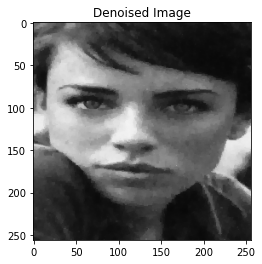

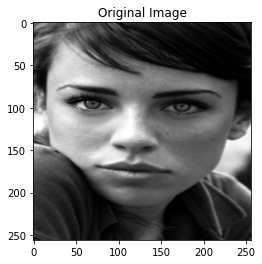

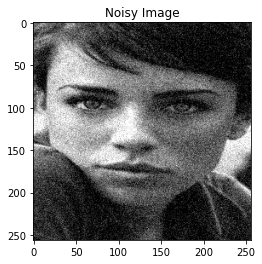

In [63]:

path = '/Users/sadegh/Downloads/Humans/256*256'
#np.random.seed(0)
#Previous calculation on colab [-2.62850676 ,-5.68326658 ,-4.82007257]
#thetaOptimal = [-2.62927107, -4.76697469, -5.71802461]


data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:50]
x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
y = y[:,:,0:50]
Bilevel = DFO_FISTA(A, b, y, x0, 2, 1+1e-3, thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],max_iter=10000)
#im = Bilevel.FISTA(thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],7)
im = Bilevel.FISTA(thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],16)*255
sample = im.reshape(256,256)
sample = Image.fromarray(sample)
plt.imshow(sample)
plt.title("Denoised Image")
plt.show()

# im = Bilevel.FISTA(-2.616204 ,  -4.7507457  ,-5.71675456,23)*255
# sample = im.reshape(256,256)
# sample = Image.fromarray(sample)
# plt.imshow(sample)
# plt.title("Denoised Image Previous")
# plt.show()

original = b[:,:,16]
original = original.reshape(256,256)*255
original = Image.fromarray(original)
plt.imshow(original)
plt.title("Original Image")
plt.show()

NImage = y[:,:,16]
NImage = NImage.reshape(256,256)*255
NImage = Image.fromarray(NImage)
plt.imshow(NImage)
plt.title("Noisy Image")
plt.show()


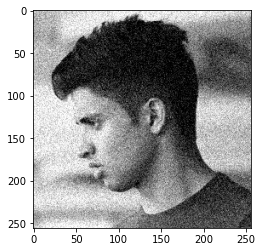

In [112]:
# Making a dataset of 2D images
import matplotlib.pyplot as plt
import numpy as np
path = '/Users/sadegh/Downloads/Humans/256*256'

X = np.zeros((256,256,50))
for i in range(50):
    im = Image.open(path + '/' + str(i) + '.png')
    data = np.asarray(im)
    X[:,:,i] = data

np.savez(path+ '/' +'Data.npz', X=X)

data = np.load(path+ '/' +'Data.npz')
X = data['X']
X= X/255
for k in range(np.shape(X)[2]):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Noise = np.random.normal(0,0.1,1)
            if X[i,j,k] + Noise > 1:
                X[i,j,k] = 1
            elif X[i,j,k] + Noise < 0:
                X[i,j,k] = 0
            else:
                X[i,j,k] = X[i,j,k] + Noise
Noisy = X*255

np.savez(path+ '/' +'DataNoisy2.npz', y=Noisy)
sample= Noisy[:,:,10]
sample = sample.reshape(256,256)
sample = Image.fromarray(sample)
plt.imshow(sample)
plt.show()




In [136]:
#HOAG Algorithm
# Adaptive Step Size
import scipy.sparse as sp
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as cg
import time


class HOAG:
    def __init__(self, A, b, y, x0, L, mu, alpha,nu, xi, max_iter=2000, tol=1e-1, lowersolver='FISTA'):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        self.matsize = np.shape(x0)
        self.x0 = np.zeros((np.shape(b)[2],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.L = L
        self.mu = mu
        self.nu = nu
        self.xi = xi
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.gtol = 0
        self.upperObjective = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.lowersolver = lowersolver
        self.success = False
        self.upperObjectivePrint = []
        self.upperTime = []
        self.upperTimesum = 0
        self.lowerTime = []
        self.lowertimesum = 0
        self.alphaHisotry = []
        self.nuHistory = []
        self.xiHistory = []
    def FISTA(self, alpha,nu,xi,i,epsilon):
        # Algorithm for solving the lower-level problem
        self.tol= epsilon
        x = self.x0[i,:]
        t = 0
        for k in range(self.max_iter):
            x_old = x
            x = np.reshape(x,(256,256))
            x = x.flatten()
            self.L = 1+ (np.exp(alpha)/np.exp(nu))* 8+np.exp(xi)
            self.mu = 1+np.exp(xi)
            tau = 1/(self.L)
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, alpha, nu, xi,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                self.lowerIterSum += k+1
                return self.x0[i,:]
            x = z -  tau*p

        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        return self.x0[i,:]
    def phi(self, x, alpha,nu,xi, i):
        phi = 0.5*np.linalg.norm(x.flatten()-self.y[:,:,i].flatten())**2 +np.exp(alpha) * self.TV2D(x, np.exp(nu)) + 0.5 *np.exp(xi) * np.linalg.norm(x)**2
        return phi
    def gradPhi(self, x, alpha,nu,xi,i):
        x = np.reshape(x,self.matsize)
        gradPhi = np.squeeze(np.asarray(x.flatten() - np.squeeze(np.asarray(self.y[:,:,i].flatten())) + np.exp(alpha) *self.gradTV2D(x, np.exp(nu)) + np.exp(xi) * x.flatten()))
        return gradPhi.flatten()
    def hessianPhi(self, x, alpha,nu,xi,i,d):
        x = np.reshape(x,self.matsize)
        d = np.reshape(d,self.matsize)
        hess = (1+np.exp(xi))*d + np.exp(alpha) * self.hessianTV2D(x, np.exp(nu),d) 
        return hess
    def TV(self,x, nu):
        return (np.sum(np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)))
    def TV2D(self,x, nu):
        x = np.reshape(x,(256,256))
        tv = 0
        tv += (np.sum(np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)))
        tv += (np.sum(np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)))
        return tv
    
    def gradTV2D(self,x, nu):

        x = np.reshape(x,(self.matsize[0],self.matsize[1]))

        grad = np.zeros(np.shape(x))
        grad[:,:-1]+= -(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        grad[:,1:] += (x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
          
        grad[:-1,:]+= -(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        grad[1:,:] += (x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)             
        return grad.flatten()
    def hessianTV2D(self,x, nu,d):
        hess = np.zeros(self.matsize)
        left = np.zeros(self.matsize)
        right = np.zeros(self.matsize)
        up = np.zeros(self.matsize)
        down = np.zeros(self.matsize)

        #Matrix-vector version
        down[:,:-1] = 1-(x[:,1:]-x[:,:-1])**2/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        hess[:,:-1] += np.multiply(-down[:,:-1] , d[:,:-1])
        up[:,1:] = 1-(x[:,1:]-x[:,:-1])**2/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
        hess[:,1:] += np.multiply(-up[:,1:] , d[:,1:])
        right[:-1,:] = 1-(x[1:,:]-x[:-1,:])**2/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        hess[:-1,:]+= np.multiply(-right[:-1,:] , d[:-1,:])
        left[1:,:] = 1-(x[1:,:]-x[:-1,:])**2/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        hess[1:,:] += np.multiply(-left[1:,:] , d[1:,:])
        hess += np.multiply(d , (left + right + up + down))
        
        return hess
    def gradTV(self,x, nu):
        grad = np.zeros(len(x))
        grad[:-1]+= -(x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        grad[1:] += (x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        
        return np.squeeze(np.asarray(grad))    
    def partialNuGradTV(self,x, nu):
        x = np.reshape(x,(self.matsize[0],self.matsize[1]))
        grad = np.zeros(np.shape(x))
        grad[:,:-1]+= nu *(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        grad[:,1:] += -nu*(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
          
        grad[:-1,:]+= nu*(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        grad[1:,:] += -nu*(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)             
        return grad 

    def CG(self,alpha,nu,xi,i,x,b,tol):
        r = b-self.hessianPhi(x,alpha,nu,xi,i,np.zeros(np.shape(x))).flatten()
        p = r.copy()
        rsold = np.linalg.norm(r)**2
        solution = np.zeros(np.shape(x))
 
        while np.linalg.norm(r)>tol:
            Ap = self.hessianPhi(x,alpha,nu,xi,i,p).flatten()
            alpha = rsold/np.dot(p.T,Ap)
            solution = solution + alpha*p
            r = r - alpha*Ap
            rsnew = np.linalg.norm(r)**2
            if np.sqrt(rsnew) < tol:
                return solution
            p = r + (rsnew/rsold)*p
            rsold = rsnew.copy()
        return solution
    def CG_scipy(self,alpha,nu,xi,i,x,b,tol):
        mv = lambda v: self.hessianPhi(x,alpha,nu,xi,i,v)
        A = LinearOperator((self.matsize[0]**2,self.matsize[1]**2), matvec=mv)
        return np.array(cg(A, b, tol = tol)[0])
    def LBFGS(self,alpha,nu,xi,i):
        x0 = self.x0.flatten()
        self.x0 = op.minimize(self.phi, x0, args=(alpha,nu,xi,i), method='L-BFGS-B', jac=self.gradPhi,options={'disp': None, 'gtol': int(np.sqrt(len(x0)))*1e-06/(1+np.exp(xi))**2},tol= 1e-8).x
        self.gtol = 0
        return np.squeeze(np.asarray(self.x0))
    def project(self,theta):
        for i in range(len(theta)):
            if theta[i] < -10:
                theta[i] = -10
            elif theta[i] > 10:
                theta[i] = 10
        return theta
        

    def solver(self):
        epsilon = 1e-1
        rho = 0.9
        inner = []
        q = []
        p = []
        self.theta = [self.alpha,self.nu,self.xi]
        C = 0.25
        factor_L_theta = 1.0
        L = 1
        self.upperTimesum = time.time()
        for k in range(200):
            if k == 199:
                epsilon = 1e-12
            upperObjectiveTemp = []
            for i in range(np.shape(self.b)[2]):
                lowertime = time.time()
                inner.append(self.FISTA(self.theta[0],self.theta[1],self.theta[2],i,epsilon))
                self.lowertimesum += time.time() - lowertime
                upperObjectiveTemp.append((np.linalg.norm(inner[-1]- np.squeeze(np.asarray(self.b[:,:,i].flatten())))**2))
                #q.append(self.CG(self.alpha,self.nu,self.xi,i,inner[-1],2*(inner[-1]- self.b[:,:,i].flatten()),tol=epsilon))
                q.append(self.CG_scipy(self.alpha,self.nu,self.xi,i,inner[-1],2*(inner[-1]- self.b[:,:,i].flatten()),tol=epsilon))
                gradPhi12 = np.concatenate((np.reshape(self.gradTV2D(inner[-1],self.nu),(self.matsize[0]**2,1)),np.reshape(self.alpha*self.partialNuGradTV(inner[-1],self.nu),(self.matsize[0]**2,1)),np.reshape(inner[-1],(self.matsize[0]**2,1))),axis=1)
                gradg2 =[0,0,np.exp(self.theta[2])]
                p.append(gradg2-np.dot(gradPhi12.T,q[-1]))
            pk = np.mean(np.array(p),axis=0)

            #     L = np.linalg.norm(pk) / np.sqrt(len(theta))
            #     stepsize = 1/L
            if k == 0:
                self.upperObjective.append(np.mean(upperObjectiveTemp)+np.exp(self.theta[2]))
                self.lowerIter.append(self.lowerIterSum)
                self.lowerTime.append(self.lowertimesum)
                L = np.linalg.norm(pk) / np.sqrt(len(self.theta))
                stepsize = 1/L
                self.theta = self.project(self.theta - stepsize* pk)
                self.alpha = self.theta[0]
                self.nu = self.theta[1]
                self.xi = self.theta[2]
                self.alphaHisotry.append(self.alpha)
                self.nuHistory.append(self.nu)
                self.xiHistory.append(self.xi)
            if k>0:
                theta_new = self.project(self.theta - stepsize* pk)
                incr = np.linalg.norm(theta_new - self.theta)

                inner = []
                upperObjectiveTemp = []
                for j in range(np.shape(self.b)[2]):
                    lowertime = time.time()
                    inner.append(self.FISTA(theta_new[0],theta_new[1],theta_new[2],j,rho*epsilon))
                    self.lowertimesum += time.time() - lowertime
                    upperObjectiveTemp.append((np.linalg.norm(inner[-1]- np.squeeze(np.asarray(self.b[:,:,j].flatten())))**2))
                g_old = self.upperObjective[-1]
                g = np.mean((upperObjectiveTemp)+np.exp(theta_new[2]))
                print("g ",g, " g_old ",g_old)
                if g <= g_old + C * rho*epsilon + epsilon * (C + factor_L_theta) * incr - factor_L_theta * (L) * incr * incr:
                    L *= 0.9
                    stepsize = 1/L
                    self.theta = self.theta - stepsize* pk
                    self.theta = self.project(self.theta)
                    self.alpha = self.theta[0]
                    self.nu = self.theta[1]
                    self.xi = self.theta[2]
                    self.alphaHisotry.append(self.alpha)
                    self.nuHistory.append(self.nu)
                    self.xiHistory.append(self.xi)
                    self.upperObjective.append(g)
                    self.lowerIter.append(self.lowerIterSum)
                    self.lowerTime.append(self.lowertimesum)
                    print("Stepsize improved")
                elif g >=  g_old:
                    print("Stepsize rejected")
                    L*=2
                    stepsize = 1/L
                    epsilon *= 0.9
                    self.upperObjective.append(g_old)
                    self.lowerIter.append(self.lowerIterSum)
                    self.lowerTime.append(self.lowertimesum)
                else:
                    self.theta = theta_new
                    self.alpha = self.theta[0]
                    self.nu = self.theta[1]
                    self.xi = self.theta[2]
                    self.alphaHisotry.append(self.alpha)
                    self.nuHistory.append(self.nu)
                    self.xiHistory.append(self.xi)
                    self.upperObjective.append(g)
                    self.lowerIter.append(self.lowerIterSum)
                    self.lowerTime.append(self.lowertimesum)
            #theta = self.project(theta)
            print("theta "+str(k+1)+ ": ",self.theta)
            inner = []
            p = []
            q = []
            if np.linalg.norm(pk)**2 < 1e-12:
                return self.theta
            if epsilon > 1e-8:
                rho = np.sqrt(1/(k+1))
                epsilon = rho*epsilon
            self.upperTime.append(time.time()-self.upperTimesum)
        return self.theta

theta 1:  [ -2.00853145  -4.91468552 -10.        ]
g  90.9581189436693  g_old  92.56416346592512
Stepsize improved
theta 2:  [ -2.01874212  -4.81389289 -10.        ]
g  88.99042936626078  g_old  90.9581189436693
theta 3:  [ -2.03038061  -4.70079    -10.        ]
g  86.95902010986389  g_old  88.99042936626078
theta 4:  [ -2.04385158  -4.57221769 -10.        ]
g  84.85392656199117  g_old  86.95902010986389
theta 5:  [ -2.05935583  -4.42733153 -10.        ]
g  82.76447133399257  g_old  84.85392656199117
theta 6:  [ -2.0769182   -4.26720751 -10.        ]
g  80.77972551610698  g_old  82.76447133399257
theta 7:  [ -2.09625234  -4.09585593 -10.        ]
g  79.04398279651133  g_old  80.77972551610698
theta 8:  [ -2.11651052  -3.92192029 -10.        ]
g  77.72372743416405  g_old  79.04398279651133
theta 9:  [ -2.1360483   -3.75974132 -10.        ]
g  76.90369164972216  g_old  77.72372743416405
theta 10:  [ -2.15258738  -3.62691618 -10.        ]
g  76.50368149914449  g_old  76.90369164972216
the

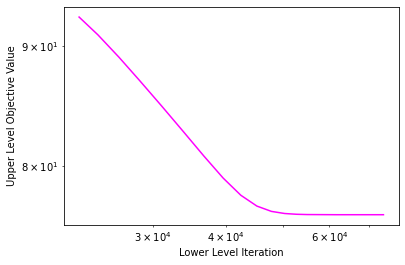

In [477]:
path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:25]

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,1]
#np.random.rand(np.shape(b)[0],np.shape(b)[1])
y = y[:,:,0:25]



Bilevel = HOAG(A, b, y, x0, 0.1, 1.2, -2,-5,-9)
result = Bilevel.solver()
thetaOptimal = result
print("Theta:" +str(thetaOptimal))
np.savez('HOAG_quadratic.npz',lowerIter=Bilevel.lowerIter,upperObjective=Bilevel.upperObjective,upperTime=Bilevel.upperTime,lowerTime=Bilevel.lowerTime,alphaHistory=Bilevel.alphaHisotry,nuHistory=Bilevel.nuHistory,xiHistory=Bilevel.xiHistory)

print("objective: " + str(Bilevel.upperObjective[-1]))
plt.plot(Bilevel.lowerIter,Bilevel.upperObjective,color='magenta')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')

In [138]:
# Reconstruction HOAG
from PIL import Image
path = '/Users/sadegh/Downloads/Humans/256*256'
data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:50]
x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])
thetaOptimal = [-2.54770567, -4.96367226, -7.97543853]
thetaOptimal2 = [ -2.17285697,  -3.46984536, -10.        ]

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
#x0 = y[:,:,3]
y = y[:,:,0:50]
# Bilevel = HOAG(A, b, y, x0, 2, 1+1e-3, thetaOptimal2[0],  thetaOptimal2[1] ,  thetaOptimal2[2],max_iter=10000)
# im = Bilevel.FISTA(thetaOptimal2[0],  thetaOptimal2[1] ,  thetaOptimal2[2],8,1e-10)*255
# sample = im.reshape(256,256)
# psnr = 10*np.log10(255**2/np.mean((sample-b[:,:,8]*255)**2))
# sample = Image.fromarray(sample)
# plt.imshow(sample)
# plt.title("Denoised Image HOAG" + " PSNR: " + str(psnr))
# plt.show()

# Bilevel = HOAG(A, b, y, x0, 2, 1+1e-3, thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],max_iter=10000)
# im = Bilevel.FISTA(thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],8,1e-10)*255
# sample = im.reshape(256,256)
# psnr = 10*np.log10(255**2/np.mean((sample-b[:,:,8]*255)**2))
# sample = Image.fromarray(sample)
# plt.imshow(sample)
# plt.title("Denoised Image DFO-FISTA" + " PSNR: " + str(psnr))
# plt.show()

# original = b[:,:,8]
# original = original.reshape(256,256)*255
# original = Image.fromarray(original)
# plt.imshow(original)
# plt.title("Original Image")
# plt.show()

# NImage = y[:,:,8]
# NImage = NImage.reshape(256,256)*255
# psnr = 10*np.log10(255**2/np.mean((NImage-b[:,:,8]*255)**2))
# NImage = Image.fromarray(NImage)
# plt.imshow(NImage)
# plt.title("Noisy Image"+ " PSNR: " + "{:.2f}".format(psnr))
# plt.show()

# fig, ax= plt.subplots(2, 2)
# ax1 = ax[0,0]
# ax2 = ax[0,1]
# ax3 = ax[1,0]
# ax4 = ax[1,1]
# NImage = y[:,:,8]
# NImage = NImage.reshape(256,256)*255
# psnr = 10*np.log10(255**2/np.mean((NImage-b[:,:,8]*255)**2))
# NImage = Image.fromarray(NImage)
# ax1.imshow(NImage)
# ax1.axes.get_xaxis().set_visible(False)
# ax1.axes.get_yaxis().set_ticks([])
# ax1.set_title("Noisy Image\n"+ " PSNR: " + "{:.2f}".format(psnr))
# ax1.set(ylabel='DFO-FISTA')

# Bilevel = HOAG(A, b, y, x0, 2, 1+1e-3, thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],max_iter=10000)
# im = Bilevel.FISTA(thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],8,1e-10)*255
# sample = im.reshape(256,256)
# psnr = 10*np.log10(255**2/np.mean((sample-b[:,:,8]*255)**2))
# sample = Image.fromarray(sample)
# ax2.imshow(sample)
# ax2.axes.get_xaxis().set_visible(False)
# ax2.axes.get_yaxis().set_visible(False)
# ax2.set_title("Denoised Image\n" + " PSNR: " + "{:.2f}".format(psnr))

# NImage = y[:,:,8]
# NImage = NImage.reshape(256,256)*255
# psnr = 10*np.log10(255**2/np.mean((NImage-b[:,:,8]*255)**2))
# NImage = Image.fromarray(NImage)
# ax3.imshow(NImage)
# ax3.axes.get_xaxis().set_visible(False)
# ax3.axes.get_yaxis().set_ticks([])
# ax3.set_title("Noisy Image")
# ax3.set(ylabel='HOAG')

# Bilevel = HOAG(A, b, y, x0, 2, 1+1e-3, thetaOptimal2[0],  thetaOptimal2[1] ,  thetaOptimal2[2],max_iter=10000)
# im = Bilevel.FISTA(thetaOptimal2[0],  thetaOptimal2[1] ,  thetaOptimal2[2],8,1e-10)*255
# sample = im.reshape(256,256)
# psnr = 10*np.log10(255**2/np.mean((sample-b[:,:,8]*255)**2))
# sample = Image.fromarray(sample)
# ax4.imshow(sample)
# ax4.axes.get_xaxis().set_visible(False)
# ax4.axes.get_yaxis().set_visible(False)
# ax4.set_title(" PSNR: " + "{:.2f}".format(psnr))
# fig.tight_layout()
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=-0.5, 
#                     hspace=0.3)
#fig.savefig("reconstruction.png", dpi=300)

# for ax in fig.get_axes():
#     ax.label_outer()

#comparing the results of the two algorithms
PSNR_DFO = []
PSNR_HOAG = []
for i in range(25):
    Bilevel = HOAG(A, b, y, x0, 2, 1+1e-3, thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],max_iter=10000)
    im = Bilevel.FISTA(thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],i,1e-10)*255
    sample = im.reshape(256,256)
    psnrDFO = 10*np.log10(255**2/np.mean((sample-b[:,:,i]*255)**2))
    PSNR_DFO.append(psnrDFO)
    im = Bilevel.FISTA(thetaOptimal2[0],  thetaOptimal2[1] ,  thetaOptimal2[2],i,1e-10)*255
    sample = im.reshape(256,256)
    psnrHOAG = 10*np.log10(255**2/np.mean((sample-b[:,:,i]*255)**2))
    PSNR_HOAG.append(psnrHOAG)
    
print("Mean PSNR of DFO-FISTA: " + "{:.2f}".format(np.mean(PSNR_DFO)))
print("Mean PSNR of HOAG: " + "{:.2f}".format(np.mean(PSNR_HOAG)))
print("Standard deviation of PSNR of DFO-FISTA: " + "{:.2f}".format(np.std(PSNR_DFO)))
print("Standard deviation of PSNR of HOAG: " + "{:.2f}".format(np.std(PSNR_HOAG)))

Mean PSNR of DFO-FISTA: 29.96
Mean PSNR of HOAG: 29.60
Standard deviation of PSNR of DFO-FISTA: 1.48
Standard deviation of PSNR of HOAG: 1.45


Initialise DFO
Upper Level Time:  27.88796615600586
Lower Level Time:  27.87425184249878
Upper Level Time:  52.00282001495361
Lower Level Time:  51.97587275505066
Upper Level Time:  56.273719787597656
Lower Level Time:  56.23378396034241
Upper Level Time:  58.96002221107483
Lower Level Time:  58.90647006034851
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1    9.33e+01  7.17e+01  9.00e-01  9.00e-01    4   
Upper Level Time:  60.744889974594116
Lower Level Time:  60.67580270767212
  1     2    7.78e+01  1.66e+01  9.00e-01  9.00e-01    5   
Upper Level Time:  61.99063992500305
Lower Level Time:  61.90665602684021
  1     3    7.78e+01  7.06e+02  4.50e-01  9.00e-02    6   
Upper Level Time:  62.71161723136902
Lower Level Time:  62.612435817718506
Upper Level Time:  67.2304310798645
Lower Level Time:  67.11624312400818
  1     4    7.76e+01  1.19e+02  2.25e-01  9.00e-02    8   
Upper Level Time:  69.71161103248596
Lower Level Time:  69.58248043060303
  1     5    7.15

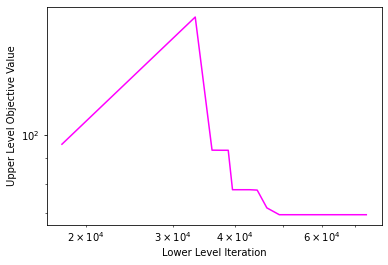

In [493]:
#2D TV
#Denoising
#Dynamic Accuracy
from functools import partial
from optparse import Option
from re import U
import numpy as np
import scipy.optimize as op
import dfols as dfo
from PIL import Image
import matplotlib.pyplot as plt
import time

class DFO_FISTA:
    def __init__(self, A, b, y, x0, L, mu, alpha,nu, xi, max_iter=2000, tol=1e-1):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        self.x0 = np.zeros((np.shape(b)[2],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.L = L
        self.mu = mu
        self.nu = nu
        self.xi = xi
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.gtol = 0
        self.matsize = np.shape(x0)
        self.upperVal = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.upperEval = 0
        self.uppersolver = dfo.DFO()
        self.upperTime = []
        self.uppertimesum = 0
        self.lowerTime = []
        self.lowertimesum = 0
        self.alphaHisotry = []
        self.nuHistory = []
        self.xiHistory = []

    def FISTA(self, alpha,nu,xi,i):
        # Algorithm for solving the lower-level problem
        lowerTime = time.time()
        x = self.x0[i,:]
        t = 0
        if 10*self.uppersolver.delta**2 == 0:
            self.tol = 1
        else:
            self.tol = 10*self.uppersolver.delta**2
        for k in range(self.max_iter):
            x_old = x
            x = np.reshape(x,(256,256))
            x = x.flatten()
            self.L = 1+ (np.exp(alpha)/np.exp(nu))* 8+np.exp(xi)
            self.mu = 1+np.exp(xi)
            tau = 1/(self.L)
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, alpha, nu, xi,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                self.lowerIterSum += k+1
                self.lowertimesum += (time.time() - lowerTime)
                self.lowerTime.append(self.lowertimesum)
                return self.x0[i,:]
            x = z -  tau*p

        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        self.lowertimesum += (time.time() - lowerTime)
        self.lowerTime.append(self.lowertimesum)

        return x

    def DFO(self):
        #theta0 = np.array([self.alpha, self.nu, self.xi])
        user_params = {'logging.save_diagnostic_info': True}
        user_params['logging.save_xk'] = True
        # Save diagnostic info to CSV
        self.uppertimesum = time.time()
        soln = self.uppersolver.solve(self.UpperLevel, np.array([self.alpha, self.nu, self.xi]),bounds=(-11*np.ones(3),11*np.ones(3)),rhoend=1e-6,print_progress=True,maxfun=200,user_params=user_params)
        soln.diagnostic_info.to_csv('DFOdetail.csv')
        self.upperEval = self.uppersolver.evalCount
        return soln
    def phi(self, x, alpha,nu,xi, i):
        phi = 0.5*np.linalg.norm(x.flatten()-self.y[:,:,i].flatten())**2 +np.exp(alpha) * self.TV2D(x, np.exp(nu)) + 0.5 *np.exp(xi) * np.linalg.norm(x)**2
        return phi
    def TV(self,x, nu):
        return (np.sum(np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)))
    def TV2D(self,x, nu):
        x = np.reshape(x,(256,256))
        tv = 0
        tv += (np.sum(np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)))
        tv += (np.sum(np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)))
        return tv
    
    def gradTV2D(self,x, nu):

        x = np.reshape(x,(self.matsize[0],self.matsize[1]))

        grad = np.zeros(np.shape(x))
        grad[:,:-1]+= -(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        grad[:,1:] += (x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
          
        grad[:-1,:]+= -(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        grad[1:,:] += (x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)             
        return grad.flatten()
    
    def gradTV(self,x, nu):
        grad = np.zeros(len(x))
        grad[:-1]+= -(x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        grad[1:] += (x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        
        return np.squeeze(np.asarray(grad))
    def gradPhi(self, x, alpha,nu,xi,i):
        x = np.reshape(x,self.matsize)
        gradPhi = np.squeeze(np.asarray(x.flatten() - np.squeeze(np.asarray(self.y[:,:,i].flatten())) + np.exp(alpha) *self.gradTV2D(x, np.exp(nu)) + np.exp(xi) * x.flatten()))
        return gradPhi.flatten()
    
    def UpperLevel(self,theta):
        alpha = theta[0]
        nu = theta[1]
        xi = theta[2]
        # FISTA
        #The only successful iterations are commented
        # if self.uppersolver.funVal==0 or self.uppersolver.funVal==None:
        #     Usquared = [r**2 for r in UL]
        #     self.upperVal.append(np.sum(Usquared))
        #     self.lowerIter.append(self.lowerIterSum)
    
        
        # if self.uppersolver.funVal!=0:
        #     self.upperVal.append(self.uppersolver.funVal)
        #     self.lowerIter.append(self.lowerIterSum)
        UL = []
        for i in range(np.shape(self.b)[2]):
            UL.append(np.sqrt(1/np.shape(self.b)[2])*np.linalg.norm(self.FISTA(alpha,nu,xi,i)- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        UL.append(np.exp(xi))
        # self.upperVal.append(np.sum(UL))
        # self.lowerIter.append(self.lowerIterSum)
        if self.uppersolver.funVal==0 or self.uppersolver.funVal==None:
            Usquared = [r**2 for r in UL]
            self.upperVal.append(np.sum(Usquared))
            self.lowerIter.append(self.lowerIterSum)
        if self.uppersolver.funVal!=0:
            self.upperVal.append(self.uppersolver.funVal)
            self.lowerIter.append(self.lowerIterSum)
        self.upperTime.append(time.time()-self.uppertimesum)
        print('Upper Level Time: ', self.upperTime[-1])
        print('Lower Level Time: ', self.lowerTime[-1])
        self.alphaHisotry.append(alpha)
        self.nuHistory.append(nu)
        self.xiHistory.append(xi)
        #LBFGS
        # UL = []
        # for i in range(np.shape(self.b)[2]):
        #     UL.append(np.linalg.norm(self.LBFGS(alpha,nu,xi,i).flatten()- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        
        return np.squeeze(np.array([UL]))
    def LBFGS(self,alpha,nu,xi,i):
        x0 = self.x0.flatten()
        # op.fmin_l_bfgs_b(self.phi, self.gradPhi, x0=self.x0, args=(i,theta))
        self.x0 = op.minimize(self.phi, x0, args=(alpha,nu,xi,i), method='L-BFGS-B', jac=self.gradPhi,options={'disp': None, 'gtol': int(np.sqrt(len(x0)))*1e-06/(1+np.exp(xi))**2},tol= 1e-8).x
        self.gtol = 0
        return np.squeeze(np.asarray(self.x0))
    
    

path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:25]
#x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,1]
y = y[:,:,0:25]
Bilevel = DFO_FISTA(A, b, y, x0, 0.1, 1.2, -2,-5,-9)
result = Bilevel.DFO()
thetaOptimal = result.x
#np.savez('DFO_FISTA_dynamic_LowStart.npz',lowerIter=Bilevel.lowerIter,upperVal=Bilevel.upperVal,upperTime=Bilevel.upperTime,lowerTime=Bilevel.lowerTime,alphaHistory=Bilevel.alphaHisotry,nuHistory=Bilevel.nuHistory,xiHistory=Bilevel.xiHistory)

print("Theta:" +str(thetaOptimal))
plt.plot(Bilevel.lowerIter,Bilevel.upperVal,color='magenta')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')
#[-2.62850676 -5.68326658 -4.82007257]



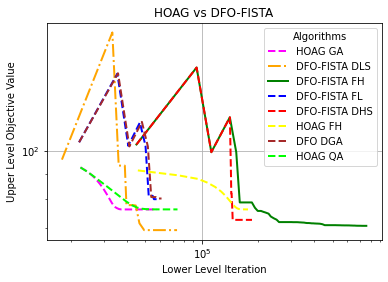

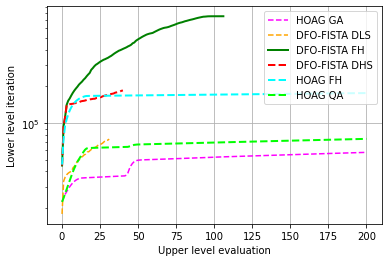

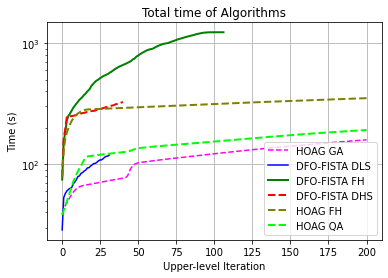

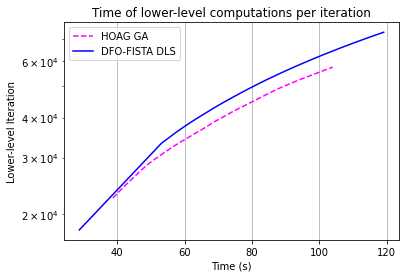

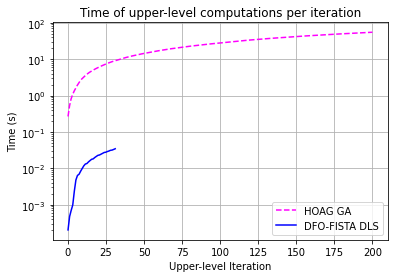

In [494]:
#Comparign DFO-FISTA with HOAG

from turtle import title


path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:25]

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,4]
#np.random.rand(np.shape(b)[0],np.shape(b)[1])
y = y[:,:,0:25]



# Bilevel1 = HOAG(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
# result = Bilevel1.solver()

#print("objective: " + str(Bilevel1.upperObjective[-1]))
HOAG = np.load('HOAG.npz')
lowerIter = HOAG['lowerIter']
upperObjective = HOAG['upperObjective']
plt.plot(lowerIter,upperObjective,'--',color='magenta',label='HOAG GA',linewidth=2)
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
#plt.xscale('log')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
# Bilevel2 = DFO_FISTA(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
# result2 = Bilevel2.DFO()
DFO_FISTA_Dynamic_LowStart = np.load('DFO_FISTA_dynamic_LowStart.npz')
lowerIter = DFO_FISTA_Dynamic_LowStart['lowerIter']
upperVal = DFO_FISTA_Dynamic_LowStart['upperVal']
plt.xticks()
plt.plot(lowerIter,upperVal,color='orange',label='DFO-FISTA DLS',linestyle='-.',linewidth=2)
# Bilevel3 = DFO_FISTA_FixedAccuracy(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
# np.savez('DFO_FISTA_FixedAccuracy.npz',lowerIter=Bilevel3.lowerIter,upperVal=Bilevel3.upperVal)
# result3 = Bilevel3.DFO()
DFO_FISTA_Dynamic_fixHigh = np.load('DFO_FISTA_Fixed_High.npz')
lowerIter = DFO_FISTA_Dynamic_fixHigh['lowerIter']
upperVal = DFO_FISTA_Dynamic_fixHigh['upperVal']
plt.plot(lowerIter,upperVal,color='green',label='DFO-FISTA FH',linestyle='-',linewidth=2)
# Bilevel4 = DFO_FISTA_FixedAccuracy(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
# Bilevel4.tol = 1e-2
# result4 = Bilevel4.DFO()
DFO_FISTA_Dynamic_fixLow = np.load('DFO_FISTA_Fixed_Low.npz')
lowerIter = DFO_FISTA_Dynamic_fixLow['lowerIter']
upperVal = DFO_FISTA_Dynamic_fixLow['upperVal']
plt.plot(lowerIter,upperVal,color='blue',label='DFO-FISTA FL',linestyle='--',linewidth=2)

DFO_FISTA_Dynamic_High = np.load('DFO_FISTA_dynamic_HighStart.npz')
lowerIter = DFO_FISTA_Dynamic_High['lowerIter']
upperVal = DFO_FISTA_Dynamic_High['upperVal']
plt.plot(lowerIter,upperVal,color='red',label='DFO-FISTA DHS',linestyle='--',linewidth=2)

HOAG_Fix_High = np.load('HOAGFixedHigh.npz')
lowerIter = HOAG_Fix_High['lowerIter']
upperObjective = HOAG_Fix_High['upperObjective']
plt.plot(lowerIter,upperObjective,color='yellow',label='HOAG FH',linestyle='--',linewidth=2)

DFO_HOAG_accuracy = np.load('DFO_Tol_HOAG.npz')
lowerIter = DFO_HOAG_accuracy['lowerIter']
upperVal = DFO_HOAG_accuracy['upperVal']
plt.plot(lowerIter,upperVal,color='brown',label='DFO DGA',linestyle='--',linewidth=2)

HOAG_Fix_High = np.load('HOAG_quadratic.npz')
lowerIter = HOAG_Fix_High['lowerIter']
upperObjective = HOAG_Fix_High['upperObjective']
plt.plot(lowerIter,upperObjective,color='lime',label='HOAG QA',linestyle='--',linewidth=2)

plt.legend(title = 'Algorithms')
plt.grid(True)
plt.title('HOAG vs DFO-FISTA')
plt.yscale('log')
plt.savefig('HOAG vs DFO-FISTA.png',dpi=300)
plt.show()


#lower level iteration vs upper level iteration
HOAG = np.load('HOAG.npz')
lowerIter = HOAG['lowerIter']
upperObjective = HOAG['upperObjective']
plt.plot(np.linspace(0,len(upperObjective),len(upperObjective)),lowerIter,color='magenta',label='HOAG GA',linestyle='--')

DFO_FISTA_Dynamic_LowStart = np.load('DFO_FISTA_dynamic_LowStart.npz')
lowerIter = DFO_FISTA_Dynamic_LowStart['lowerIter']
upperVal = DFO_FISTA_Dynamic_LowStart['upperVal']
plt.plot(np.linspace(0,len(upperVal),len(upperVal)),lowerIter,color='orange',label='DFO-FISTA DLS',linestyle='--')

DFO_FISTA_Dynamic_fixHigh = np.load('DFO_FISTA_Fixed_High.npz')
lowerIter = DFO_FISTA_Dynamic_fixHigh['lowerIter']
upperVal = DFO_FISTA_Dynamic_fixHigh['upperVal']
plt.plot(np.linspace(0,len(upperVal),len(upperVal)),lowerIter,color='green',label='DFO-FISTA FH',linestyle='-',linewidth=2)

DFO_FISTA_Dynamic_High = np.load('DFO_FISTA_dynamic_HighStart.npz')
lowerIter = DFO_FISTA_Dynamic_High['lowerIter']
upperVal = DFO_FISTA_Dynamic_High['upperVal']
plt.plot(np.linspace(0,len(upperVal),len(upperVal)),lowerIter,color='red',label='DFO-FISTA DHS',linestyle='--',linewidth=2)

HOAG_Fix_High = np.load('HOAGFixedHigh.npz')
lowerIter = HOAG_Fix_High['lowerIter']
upperObjective = HOAG_Fix_High['upperObjective']
plt.plot(np.linspace(0,len(upperObjective),len(upperObjective)),lowerIter,color='cyan',label='HOAG FH',linestyle='--',linewidth=2)

HOAG_Fix_High = np.load('HOAG_quadratic.npz')
lowerIter = HOAG_Fix_High['lowerIter']
upperObjective = HOAG_Fix_High['upperObjective']
plt.plot(np.linspace(0,len(upperObjective),len(upperObjective)),lowerIter,color='lime',label='HOAG QA',linestyle='--',linewidth=2)

plt.xlabel('Upper level evaluation')
plt.ylabel('Lower level iteration')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig('HOAG vs DFO-FISTA upper-lower.png',dpi=300)
plt.show()

#HOAG vs DFO-FISTA time
HOAG = np.load('HOAG.npz')
lowerIter = HOAG['lowerIter']
upperObjective = HOAG['upperObjective']
duration = HOAG['upperTime']
plt.plot(np.linspace(0,len(upperObjective),len(upperObjective)),duration,color='magenta',label='HOAG GA',linestyle='--')

DFO_FISTA_Dynamic_LowStart = np.load('DFO_FISTA_dynamic_LowStart.npz')
lowerIter = DFO_FISTA_Dynamic_LowStart['lowerIter']
upperVal = DFO_FISTA_Dynamic_LowStart['upperVal']
duration = DFO_FISTA_Dynamic_LowStart['upperTime']
plt.plot(np.linspace(0,len(upperVal),len(upperVal)),duration,color='blue',label='DFO-FISTA DLS')

DFO_FISTA_Dynamic_fixHigh = np.load('DFO_FISTA_Fixed_High.npz')
lowerIter = DFO_FISTA_Dynamic_fixHigh['lowerIter']
upperVal = DFO_FISTA_Dynamic_fixHigh['upperVal']
duration = DFO_FISTA_Dynamic_fixHigh['upperTime']
plt.plot(np.linspace(0,len(upperVal),len(upperVal)),duration,color='green',label='DFO-FISTA FH',linestyle='-',linewidth=2)

# DFO_FISTA_Dynamic_fixLow = np.load('DFO_FISTA_Fixed_Low.npz')
# lowerIter = DFO_FISTA_Dynamic_fixLow['lowerIter']
# upperVal = DFO_FISTA_Dynamic_fixLow['upperVal']
# plt.plot(np.linspace(0,len(upperVal),len(upperVal)),lowerIter,color='blue',label='DFO-FISTA FL',linestyle='--',linewidth=2)

DFO_FISTA_Dynamic_High = np.load('DFO_FISTA_dynamic_HighStart.npz')
lowerIter = DFO_FISTA_Dynamic_High['lowerIter']
upperVal = DFO_FISTA_Dynamic_High['upperVal']
duration = DFO_FISTA_Dynamic_High['upperTime']
plt.plot(np.linspace(0,len(upperVal),len(upperVal)),duration,color='red',label='DFO-FISTA DHS',linestyle='--',linewidth=2)

HOAG_Fix_High = np.load('HOAGFixedHigh.npz')
lowerIter = HOAG_Fix_High['lowerIter']
upperObjective = HOAG_Fix_High['upperObjective']
duration = HOAG_Fix_High['upperTime']
plt.plot(np.linspace(0,len(upperObjective),len(upperObjective)),duration,color='olive',label='HOAG FH',linestyle='--',linewidth=2)

# DFO_HOAG_accuracy = np.load('DFO_Tol_HOAG.npz')
# lowerIter = DFO_HOAG_accuracy['lowerIter']
# upperVal = DFO_HOAG_accuracy['upperVal']
# plt.plot(np.linspace(0,len(upperVal),len(upperVal)),lowerIter,color='brown',label='DFO DGA',linestyle='--',linewidth=2)

HOAG_Fix_High = np.load('HOAG_quadratic.npz')
lowerIter = HOAG_Fix_High['lowerIter']
upperObjective = HOAG_Fix_High['upperObjective']
duration = HOAG_Fix_High['upperTime']
plt.plot(np.linspace(0,len(upperObjective),len(upperObjective)),duration,color='lime',label='HOAG QA',linestyle='--',linewidth=2)

plt.xlabel('Upper-level Iteration')
plt.ylabel('Time (s)')
plt.title('Total time of Algorithms')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig('HOAG vs DFO-FISTA time.png',dpi=300)
plt.show()

#Lower time
HOAG = np.load('HOAG.npz')
lowerIter = HOAG['lowerIter']
duration = HOAG['lowerTime']
plt.plot(duration,lowerIter,color='magenta',label='HOAG GA',linestyle='--')

DFO_FISTA_Dynamic_LowStart = np.load('DFO_FISTA_dynamic_LowStart.npz')
lowerIter = DFO_FISTA_Dynamic_LowStart['lowerIter']
duration = DFO_FISTA_Dynamic_LowStart['lowerTime']
plt.plot(duration,lowerIter,color='blue',label='DFO-FISTA DLS')
plt.xlabel('Time (s)')
plt.ylabel('Lower-level Iteration')
plt.title('Time of lower-level computations per iteration')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig('HOAG vs DFO-FISTA lower time.png',dpi=300)
plt.show()

#upper time
HOAG = np.load('HOAG.npz')
lowerIter = HOAG['lowerIter']
duration = HOAG['lowerTime']
Totalduration = HOAG['upperTime']
upperObjective = HOAG['upperObjective']
plt.plot(np.linspace(0,len(upperObjective),len(upperObjective)),Totalduration-duration,color='magenta',label='HOAG GA',linestyle='--')

DFO_FISTA_Dynamic_LowStart = np.load('DFO_FISTA_dynamic_LowStart.npz')
lowerIter = DFO_FISTA_Dynamic_LowStart['lowerIter']
duration = DFO_FISTA_Dynamic_LowStart['lowerTime']
Totalduration = DFO_FISTA_Dynamic_LowStart['upperTime']
upperVal = DFO_FISTA_Dynamic_LowStart['upperVal']
plt.plot(np.linspace(0,len(upperVal),len(upperVal)),Totalduration-duration,color='blue',label='DFO-FISTA DLS')
plt.ylabel('Time (s)')
plt.xlabel('Upper-level Iteration')
plt.title('Time of upper-level computations per iteration')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig('HOAG vs DFO-FISTA upper time.png',dpi=300)
plt.show()


Initialise DFO
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1    2.34e+03  7.47e+03  2.00e-01  2.00e-01   12   
  1     2    1.35e+03  4.61e+03  8.00e-01  2.00e-01   13   
  1     3    5.93e+02  1.93e+03  8.00e-01  2.00e-01   14   
  1     4    5.92e+02  1.51e+03  4.00e-01  2.00e-01   15   
  1     5    5.92e+02  3.27e+03  2.00e-01  2.00e-01   16   
  1     6    5.92e+02  1.55e+04  2.00e-01  2.00e-01   17   
  1     7    5.92e+02  2.09e+04  1.00e-01  2.00e-02   18   
  1     8    5.92e+02  2.96e+04  5.00e-02  2.00e-02   20   
  1     9    5.92e+02  1.91e+04  2.00e-02  2.00e-02   22   
  1    10    5.92e+02  9.79e+03  2.00e-02  2.00e-02   24   
  1    11    5.92e+02  4.56e+02  2.00e-02  2.00e-02   26   
  1    12    5.92e+02  3.53e+00  2.00e-02  2.00e-02   28   
  1    13    5.92e+02  2.51e+00  2.00e-02  2.00e-02   29   
  1    14    5.92e+02  1.83e+00  2.00e-02  2.00e-02   30   
  1    15    5.92e+02  2.08e+00  2.00e-02  2.00e-02   31   
  1    16    5.92e+02  2.

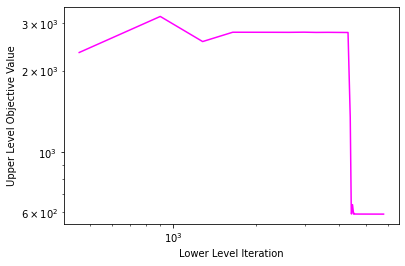

In [30]:
#Convolutioal filters
#Denoising
#Dynamic Accuracy DFO-FISTA
# Gradient calculated manually
from functools import partial
from optparse import Option
from re import U
import numpy as np
import scipy.optimize as op
import dfols as dfo
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage

class DFO_FISTA_Conv:
    def __init__(self, A, b, y, x0, theta, max_iter=2000, tol=1e-8):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        self.x0 = np.zeros((np.shape(b)[2],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.theta = theta
        self.max_iter = max_iter
        self.tol = tol
        self.s = 3
        self.gtol = 0
        self.matsize = np.shape(x0)
        self.upperVal = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.upperEval = 0
        self.uppersolver = dfo.DFO()
    def FISTA(self, theta,i):
        # Algorithm for solving the lower-level problem
        x = self.x0[i,:]
        t = 0
        if 10*self.uppersolver.delta**2 == 0:
            self.tol = 1e-8
        else:
            self.tol = 10*self.uppersolver.delta**2
        for k in range(self.max_iter):
            x_old = x
            x = np.reshape(x,(256,256))
            x = x.flatten()
            self.L = 1+ (1/theta[1])* np.exp(theta[0]) + np.linalg.norm(theta[2:])**2
            self.mu = 1
            tau = 1/(self.L)
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, theta,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                self.lowerIterSum += k+1
                return self.x0[i,:]
            x = z -  tau*p

        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        return x

    def DFO(self):
        #theta0 = np.array([self.alpha, self.nu, self.xi])
        user_params = {'logging.save_diagnostic_info': True}
        user_params['logging.save_xk'] = True
        # Save diagnostic info to CSV
        soln = self.uppersolver.solve(self.UpperLevel, np.array(self.theta),bounds=(-10*np.ones(11),10*np.ones(11)),rhoend=1e-8,print_progress=True,maxfun=150,user_params=user_params)
        #soln.diagnostic_info.to_csv('DFOdetail.csv')
        self.upperEval = self.uppersolver.evalCount
        return soln
    def convolution(self,x,c):
        return ndimage.convolve(x, c, mode='reflect', cval=0.0)
    def phi(self, x, theta, i):
        phi = 0.5*np.linalg.norm(x.flatten()-self.y[:,:,i].flatten())**2 +np.exp(theta[0]) * (np.sum(np.sqrt(np.abs(self.convolution(x,np.reshape(theta[2:],(self.s,self.s))).flatten())**2+ theta[1]**2)))
        return phi
    def gradPhi(self, x, theta,i):
        x = np.reshape(x,self.matsize)
        cx = self.convolution(x,np.reshape(theta[2:],(self.s,self.s)))
        phidot = cx/((np.sqrt(np.abs(cx)**2+ theta[1]**2)))
        cTcx = self.convolution(phidot.T,np.reshape(theta[2:],(self.s,self.s))).flatten()
        gradPhi = np.squeeze(np.asarray(x.flatten() - np.squeeze(np.asarray(self.y[:,:,i].flatten())) + np.exp(theta[0]) *cTcx))
        return gradPhi.flatten()
    
    def UpperLevel(self,theta):

        # FISTA
        UL = []
        for i in range(np.shape(self.b)[2]):
            UL.append(np.sqrt(1/np.shape(self.b)[2])*np.linalg.norm(self.FISTA(theta,i)- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        Usquared = [r**2 for r in UL]
        self.upperVal.append(np.sum(Usquared))
        self.lowerIter.append(self.lowerIterSum)

        return np.squeeze(np.array([UL]))

    
    

path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:10]
#x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,1]
y = y[:,:,0:10]
theta = np.array(np.random.rand(11))
theta[0] = -2
theta[1] = -2
Bilevel = DFO_FISTA_Conv(A, b, y, x0, theta)
result = Bilevel.DFO()
thetaOptimal = result.x
print("Theta:" +str(thetaOptimal))

plt.plot(Bilevel.lowerIter,Bilevel.upperVal,color='magenta')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')
#[-2.62850676 -5.68326658 -4.82007257]



Initialise DFO
f =  17424.987293526247
FISTA 1 done
FISTA 2 done
FISTA 3 done
FISTA 4 done
FISTA 5 done
FISTA 6 done
FISTA 7 done
FISTA 8 done
FISTA 9 done
FISTA 10 done
FISTA 11 done
FISTA 12 done
FISTA 13 done
FISTA 14 done
FISTA 15 done
FISTA 16 done
FISTA 17 done
FISTA 18 done
FISTA 19 done
FISTA 20 done
FISTA 21 done
FISTA 22 done
FISTA 23 done
FISTA 24 done
FISTA 25 done
f =  17897.00568673251
FISTA 1 done
FISTA 2 done
FISTA 3 done
FISTA 4 done
FISTA 5 done
FISTA 6 done
FISTA 7 done
FISTA 8 done
FISTA 9 done
FISTA 10 done
FISTA 11 done
FISTA 12 done
FISTA 13 done
FISTA 14 done
FISTA 15 done
FISTA 16 done
FISTA 17 done
FISTA 18 done
FISTA 19 done
FISTA 20 done
FISTA 21 done
FISTA 22 done
FISTA 23 done
FISTA 24 done
FISTA 25 done
f =  17886.787948007423
f =  17109.191113550183
f =  17592.43966258871
f =  17597.68524787396
f =  17590.955897185373
f =  17597.63191408222
f =  17606.31421104136
f =  17598.197096523207
f =  17590.62172037009
f =  17596.644128459153
f =  17590.2136734851

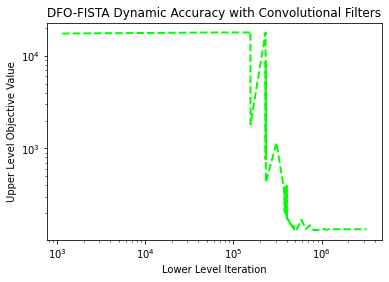

In [6]:
#Convolutioal filters 
#Pytorch implementation
#Denoising
#Dynamic Accuracy DFO-FISTA
from functools import partial
from optparse import Option
from re import U
import numpy as np
import scipy.optimize as op
import dfols as dfo
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.autograd import Variable
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as cg


class DFO_FISTA_Conv:
    def __init__(self, A, b, y, x0, theta, max_iter=3000, tol=1e-6):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        self.x0 = np.zeros((np.shape(b)[2],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.theta = theta
        self.max_iter = max_iter
        self.tol = tol
        self.s = 3
        self.gtol = 0
        self.matsize = np.shape(x0)
        self.upperVal = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.upperEval = 0
        self.uppersolver = dfo.DFO()
    def FISTA(self, theta,i):
        # Algorithm for solving the lower-level problem
        x = self.x0[i,:]
        t = 0
        if 10*self.uppersolver.delta**2 == 0:
            self.tol = 1e-1
        else:
            self.tol = 10*self.uppersolver.delta**2
        for k in range(self.max_iter):
            x_old = x
            x = np.reshape(x,(256,256))
            x = x.flatten()
            self.L = 1+ (1/theta[1])* np.exp(theta[0]) + np.linalg.norm(theta[2:])**2
            self.mu = 1
            tau = 1/(self.L)
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, theta,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                self.lowerIterSum += k+1
                return self.x0[i,:]
            x = z -  tau*p

        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        print("FISTA " +str(i+1)+" done")
        return x

    def DFO(self):
        #theta0 = np.array([self.alpha, self.nu, self.xi])
        user_params = {'logging.save_diagnostic_info': True}
        user_params['logging.save_xk'] = True
        # Save diagnostic info to CSV
        soln = self.uppersolver.solve(self.UpperLevel, np.array(self.theta),bounds=(-7*np.ones(12),7*np.ones(12)),rhoend=5*1e-6,print_progress=True,user_params=user_params)
        #soln.diagnostic_info.to_csv('DFOdetail.csv')
        self.upperEval = self.uppersolver.evalCount
        return soln
    def convolution(self,x,theta,k):
        conv = nn.Conv2d(1,1,3)
        conv.weight.data = torch.reshape((theta[3+9*k:3+9*(k+1)]),(3,3)).unsqueeze (0).unsqueeze (0) # add singleton channels dimensions
        conv.bias.data.zero_()
        if type(x)==np.ndarray:
            x = torch.FloatTensor(x)
        #x = torch.autograd.Variable (torch.FloatTensor (x))
        conv = conv(x.unsqueeze (0).unsqueeze (0))
        conv = torch.flatten(conv)
        conv = torch.sum(torch.sqrt(torch.abs(torch.pow(conv,2)+torch.exp(torch.FloatTensor (theta[2])))))
        return conv
    def phi(self, x,theta, i):
        x = np.reshape(x,(256,256))
        # if type(theta) == np.ndarray:
        #     #theta = torch.tensor((theta), requires_grad=True).float()
        #     theta = torch.FloatTensor (theta)
        #     theta = Variable(theta, requires_grad=True)
        phi = 0.5*np.linalg.norm(x.flatten()-self.y[:,:,i].flatten())**2 +torch.exp(torch.FloatTensor (theta[0]))*(torch.exp(torch.FloatTensor (theta[1]))* self.convolution(x,theta,0))
        #+torch.exp(torch.FloatTensor (theta[2]))* self.convolution(x,theta,1)+torch.exp(torch.FloatTensor (theta[3]))* self.convolution(x,theta,2)+torch.exp(torch.FloatTensor (theta[4]))* self.convolution(x,theta,3)+torch.exp(torch.FloatTensor (theta[5]))* self.convolution(x,theta,4)
        return phi
    def gradPhi(self, x, theta,i):
        x = np.reshape(x,(256,256))
        x = Variable (torch.FloatTensor(x), requires_grad=True)
        # theta = torch.FloatTensor (theta)
        # theta = Variable(theta, requires_grad=True)
        if type(theta) == np.ndarray:
            theta = Variable (torch.FloatTensor(theta), requires_grad=True)
            
        phi = 0.5*torch.linalg.norm(torch.flatten(x)-torch.tensor(self.y[:,:,i].flatten()))**2 +torch.exp(torch.FloatTensor (theta[0]))*(torch.exp(torch.FloatTensor (theta[1]))* self.convolution(x,theta,0))
        #+torch.exp(torch.FloatTensor (theta[2]))* self.convolution(x,theta,1)+torch.exp(torch.FloatTensor (theta[3]))* self.convolution(x,theta,2)+torch.exp(torch.FloatTensor (theta[4]))* self.convolution(x,theta,3)+torch.exp(torch.FloatTensor (theta[5]))* self.convolution(x,theta,4)
        grad = phi.backward()
        return x.grad.detach().numpy().flatten()
    
    def UpperLevel(self,theta):

        # FISTA
        UL = []
        for i in range(np.shape(self.b)[2]):
            UL.append(np.sqrt(1/np.shape(self.b)[2])*np.linalg.norm(self.FISTA(theta,i)- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        Usquared = [r**2 for r in UL]
        self.upperVal.append(np.sum(Usquared))
        self.lowerIter.append(self.lowerIterSum)
        print("f = ", self.upperVal[-1])
        return np.squeeze(np.array([UL]))

path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:25]
#x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,1]
y = y[:,:,0:25]
theta = np.array(np.ones(12))
#-np.array(np.random.randn(52))
theta[0] = -3
theta[2] = -1
# theta = [-2.13992777, -0.54547702,  0.41561692, -0.951482,   -1.17756152,  1.0787884, 1.08304873, -1.13397091, -0.45887538, -1.27170172,  0.06660479,  0.55335602, -0.19291492,  0.29559634, -0.99926039, -0.38236902,  0.77525075, -0.41309977, -0.50165795, -1.09610145,  0.98342242, -0.0642842, 1.70870378, -0.70877556, -0.36309232, -0.03425583, 1.34183294, -0.84891413, -0.95879516, 0.85385141, 0.66604129, 0.03280837]
#theta = [-1.43921807e+00, -9.17631944e-01,  8.81194131e-02, -2.77402785e-01, -2.17536973e-01, -1.47510170e+00, -3.84146929e-04, -2.63863815e-01, 8.15598930e-01,  2.80550566e+00, -1.43379035e+00]
#theta = Variable(torch.ones(11), requires_grad=True)
Bilevel = DFO_FISTA_Conv(A, b, y, x0, theta)
result = Bilevel.DFO()
thetaOptimal = result.x
print("Theta:" +str(thetaOptimal))

plt.plot(Bilevel.lowerIter,Bilevel.upperVal,color='lime',linestyle='dashed',linewidth=2)
plt.title('DFO-FISTA Dynamic Accuracy with Convolutional Filters')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')
plt.savefig('DFO-FISTA Dynamic Accuracy with Convolutional Filters1.png',dpi=300)



Initialise DFO


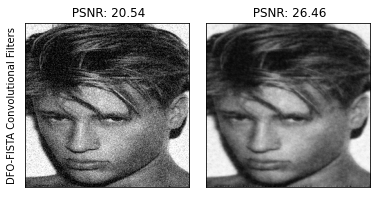

In [11]:
#[-2.70240089 -0.2136612  -0.6461532  -0.38267236 -1.87601398 -1.41098418
#   1.5118099  -0.52890329  0.15060124 -0.52525432 -0.32801627  0.10965946
#  -0.08285805  1.04506835 -1.15886413 -0.00357643 -0.17004003 -0.40434421
#  -0.84497886 -0.51925777  0.6972674   0.19976565  2.18197729 -1.28046707
#  -0.42859662  1.54373936 -1.41045928 -0.12458465 -0.18750504  1.88644134
#  -1.28965766  1.32156877]
#thetaOptimal = [-3.93780056e+00,  2.47102721e+00,  7.93997254e-01, -1.74275491e-01, 1.51977859e+00,  1.58994402e-03, -2.90761319e-01,  3.45783575e-01, 9.51402926e-01, -6.14087287e-01,  4.57329154e-01, -1.60644830e-01, 1.01199710e+00, -3.68134846e-01, -5.82217761e-01, -1.06366216e+00, 1.56927988e+00,  1.26971901e-01, -1.89635627e+00,  1.57464242e+00, -1.59708313e+00,  3.73675020e-02, -8.77935498e-01,  7.75901442e-01, 2.87658140e-01,  6.42472389e-01, -4.00436338e-01,  8.86104767e-01, -4.23071786e-02,  6.43561406e-01, -1.63749959e+00,  8.89671534e-01, -8.93794910e-01, -6.22545432e-03,  3.78612413e-01, -1.43990281e+00, 4.87895685e-01,  1.05240517e+00, -1.44643363e+00, -5.68445565e-01, 1.69041587e+00,  1.45882513e-01, -2.79152344e-01,  1.16292349e+00, 1.55888105e+00, -8.02302822e-01,  8.93596232e-01, -7.48272956e-01, 1.13024310e+00,  2.65420597e-01, -2.04291641e+00, -1.25524155e+00]
Bilevel.tol = 1e-12
#1 layer 40 data
thetaOptimal = [-5.29698514,  4.10731418, -1.41813518,  0.83786449, -0.15392873, -0.35301812, 0.78465174, -2.59338315,  0.05073625, -0.00996758,  1.06651579,  0.37602259]

Bilevel = DFO_FISTA_Conv(A, b, y, x0, thetaOptimal)
fig, ax= plt.subplots(1, 2)
ax1 = ax[0]
ax2 = ax[1]
# plt.imshow(sample)
# plt.title("Denoised Image DFO-FISTA Convolution")
# plt.show()

noisy = y[:,:,9]*255
sample = Image.fromarray(noisy)
ax1.imshow(sample)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_ticks([])
psnr = 10*np.log10(255**2/np.mean((sample-b[:,:,9]*255)**2))
ax1.set_title(" PSNR: " + "{:.2f}".format(psnr))
ax1.set_ylabel("DFO-FISTA Convolutional Filters")
im = Bilevel.FISTA(np.array(thetaOptimal),9)*255
sample = im.reshape(256,256)
sample = Image.fromarray(sample)
ax2.imshow(sample)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
psnr = 10*np.log10(255**2/np.mean((sample-b[:,:,9]*255)**2))
ax2.set_title(" PSNR: " + "{:.2f}".format(psnr))
fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.3)
fig.savefig("reconstruction covolutional.png", dpi=300)


In [8]:
#Unrolled GD  
import scipy.sparse as sp
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as cg
import time

class unrolled:
    def __init__(self, A, b, y, x0, alpha,nu, xi, max_iter=50):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        self.matsize = np.shape(x0)
        self.x0 = np.zeros((np.shape(b)[2],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.nu = nu
        self.xi = xi
        self.alpha = alpha
        self.max_iter = max_iter
        self.gtol = 0
        self.upperObjective = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.upperTime = []
        self.uppertimesum = 0
        self.lowerTime = []
        self.lowertimesum = 0
        self.alphaHisotry = []
        self.nuHistory = []
        self.xiHistory = []
    def GD(self, alpha,nu,xi,i):
        # Algorithm for solving the lower-level problem
        lowertime = time.time()
        x = self.x0[i,:]
        si = []
        self.L = 1+ (np.exp(alpha)/np.exp(nu))* 8+np.exp(xi)
        self.mu = 1+np.exp(xi)
        self.tau = 1/(self.L)
        si.append(x)
        for k in range(self.max_iter):
            x_old = x
            x = x.flatten()
            p = self.gradPhi(x, alpha, nu, xi,i)
            x = x -  self.tau*p
            self.lowerIterSum += k+1
            si.append(x)
        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        self.lowertimesum += time.time() - lowertime
        return si
    def phi(self, x, alpha,nu,xi, i):
        phi = 0.5*np.linalg.norm(x.flatten()-self.y[:,:,i].flatten())**2 +np.exp(alpha) * self.TV2D(x, np.exp(nu)) + 0.5 *np.exp(xi) * np.linalg.norm(x)**2
        return phi
    def gradPhi(self, x, alpha,nu,xi,i):
        x = np.reshape(x,self.matsize)
        gradPhi = np.squeeze(np.asarray(x.flatten() - np.squeeze(np.asarray(self.y[:,:,i].flatten())) + np.exp(alpha) *self.gradTV2D(x, np.exp(nu)) + np.exp(xi) * x.flatten()))
        return gradPhi.flatten()
    def hessianPhi(self, x, alpha,nu,xi,d):
        x = np.reshape(x,self.matsize)
        d = np.reshape(d,self.matsize)
        hess = (1+np.exp(xi))*d + np.exp(alpha) * self.hessianTV2D(x, np.exp(nu),d) 
        return hess
    def TV(self,x, nu):
        return (np.sum(np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)))
    def TV2D(self,x, nu):
        x = np.reshape(x,(256,256))
        tv = 0
        tv += (np.sum(np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)))
        tv += (np.sum(np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)))
        return tv
    
    def gradTV2D(self,x, nu):

        x = np.reshape(x,(self.matsize[0],self.matsize[1]))

        grad = np.zeros(np.shape(x))
        grad[:,:-1]+= -(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        grad[:,1:] += (x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
          
        grad[:-1,:]+= -(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        grad[1:,:] += (x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)             
        return grad.flatten()
    def hessianTV2D(self,x, nu,d):
        hess = np.zeros(self.matsize)
        left = np.zeros(self.matsize)
        right = np.zeros(self.matsize)
        up = np.zeros(self.matsize)
        down = np.zeros(self.matsize)

        #Matrix-vector version
        down[:,:-1] = 1-(x[:,1:]-x[:,:-1])**2/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        hess[:,:-1] += np.multiply(-down[:,:-1] , d[:,:-1])
        up[:,1:] = 1-(x[:,1:]-x[:,:-1])**2/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
        hess[:,1:] += np.multiply(-up[:,1:] , d[:,1:])
        right[:-1,:] = 1-(x[1:,:]-x[:-1,:])**2/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        hess[:-1,:]+= np.multiply(-right[:-1,:] , d[:-1,:])
        left[1:,:] = 1-(x[1:,:]-x[:-1,:])**2/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        hess[1:,:] += np.multiply(-left[1:,:] , d[1:,:])
        hess += np.multiply(d , (left + right + up + down))
        
        return hess
    def gradTV(self,x, nu):
        grad = np.zeros(len(x))
        grad[:-1]+= -(x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        grad[1:] += (x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        
        return np.squeeze(np.asarray(grad))    
    def partialNuGradTV(self,x, nu):
        x = np.reshape(x,(self.matsize[0],self.matsize[1]))
        grad = np.zeros(np.shape(x))
        grad[:,:-1]+= nu *(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        grad[:,1:] += -nu*(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
          
        grad[:-1,:]+= nu*(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        grad[1:,:] += -nu*(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)             
        return grad 

    def project(self,theta):
        for i in range(len(theta)):
            if theta[i] < -10:
                theta[i] = -10
            elif theta[i] > 10:
                theta[i] = 10
        return theta
        
    def H(self,x,d):
        sum = 0
        for i in range(self.max_iter):
            prod = d
            for t in range (self.max_iter,i+1,-1):
                prod = prod - self.tau * self.hessianPhi(x[t],self.alpha,self.nu,self.xi,prod).flatten()
            prod = -np.dot(np.concatenate((np.reshape(self.gradTV2D(x[i],self.nu),(self.matsize[0]**2,1)),np.reshape(self.alpha*self.partialNuGradTV(x[i],self.nu),(self.matsize[0]**2,1)),np.reshape(x[i],(self.matsize[0]**2,1))),axis=1).T,prod)
            sum += prod
        return sum 
    def solver(self):

        p = []
        self.theta = [self.alpha,self.nu,self.xi]

        for k in range(40):
            self.uppertimesum = time.time()
            if k<5:
                self.max_iter = 100
            upperObjectiveTemp = []
            for i in range(np.shape(self.b)[2]):
                inner = self.GD(self.theta[0],self.theta[1],self.theta[2],i)
                upperObjectiveTemp.append((np.linalg.norm(inner[-1]- np.squeeze(np.asarray(self.b[:,:,i].flatten())))**2))
                p.append(self.H(inner,2*(inner[-1]- self.b[:,:,i].flatten())))
            pk = np.mean(np.array(p),axis=0)
            print("gradient norm ",np.linalg.norm(pk))
            self.lowerTime.append(self.lowertimesum)
            self.upperObjective.append(np.mean(upperObjectiveTemp))
            print("Objective value = ",self.upperObjective[-1])
            self.lowerIter.append(self.lowerIterSum)
            L = np.linalg.norm(pk) / np.sqrt(len(self.theta))
            stepsize = 1/L
            self.theta = self.project(self.theta - stepsize* pk)
            self.alpha = self.theta[0]
            self.nu = self.theta[1]
            self.xi = self.theta[2]
            self.alphaHisotry.append(self.alpha)
            self.nuHistory.append(self.nu)
            self.xiHistory.append(self.xi)


            #theta = self.project(theta)
            print("theta "+str(k+1)+ ": ",self.theta)
            p = []
            self.upperTime.append(time.time()-self.uppertimesum)


        return self.theta
    
    
path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:25]
#x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,1]
y = y[:,:,0:25]
theta = [-2,-5,-9]
Bilevel = unrolled(A, b, y, x0, theta[0], theta[1], theta[2])
result = Bilevel.solver()
thetaOptimal = result
print("Theta:" +str(thetaOptimal))
np.savez('Unrolled.npz',lowerIter=Bilevel.lowerIter,upperObjective=Bilevel.upperObjective,upperTime=Bilevel.upperTime,lowerTime=Bilevel.lowerTime,alphaHistory=Bilevel.alphaHisotry,nuHistory=Bilevel.nuHistory,xiHistory=Bilevel.xiHistory)

plt.plot(Bilevel.lowerIter,Bilevel.upperObjective,color='blue')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')

gradient norm  664803.0099353698
Objective value =  3165.368941989908
theta 1:  [-1.99545141 -5.04548587 -7.26855253]
gradient norm  210072.4952796701
Objective value =  1064.2097588599042
theta 2:  [-1.99787039 -5.02113153 -5.53667464]
gradient norm  55172.78399926684
Objective value =  404.4727346495365
theta 3:  [-2.01100833 -4.88933738 -3.80969529]
gradient norm  27500.197095119416
Objective value =  185.17990699637255
theta 4:  [-2.03210495 -4.68190496 -5.52915064]
gradient norm  30241.106846455335
Objective value =  113.97749465292152
theta 5:  [-2.04592347 -4.55043383 -7.25614931]
gradient norm  23412.617953615256
Objective value =  93.38292098124248
theta 6:  [-2.06010128 -4.41844067 -8.98310524]
gradient norm  18560.43806692397
Objective value =  86.48330410206727
theta 7:  [ -2.07622581  -4.27166818 -10.        ]
gradient norm  15628.232545460189
Objective value =  83.25969937489356
theta 8:  [ -2.09456302  -4.10903644 -10.        ]
gradient norm  13418.966566261253
Objective

KeyboardInterrupt: 

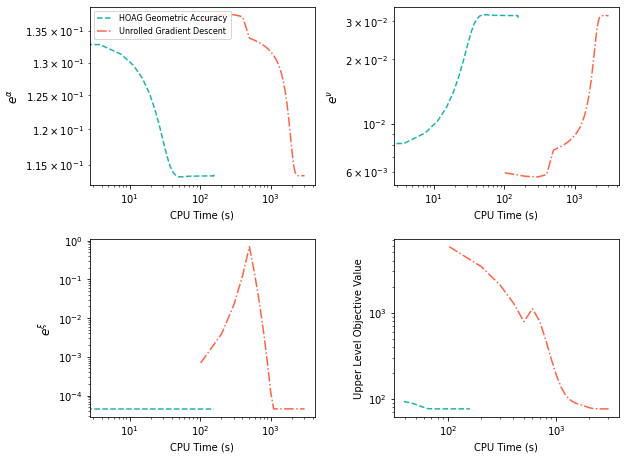

In [146]:
from tkinter import font
import matplotlib.pyplot as plt
import numpy as np
import torch
HOAG = np.load('HOAG.npz')
lowerIterH = HOAG['lowerIter']
durationH = HOAG['lowerTime']
TotaldurationH = HOAG['upperTime']
upperObjectiveH = HOAG['upperObjective']
alphaH = np.exp(HOAG['alphaHistory'])
nuH = np.exp(HOAG['nuHistory'])
xiH = np.exp(HOAG['xiHistory'])
#plt.plot(np.linspace(0,Totalduration[-1],len(alpha)),alpha,color='lightseagreen',label='HOAG Geometric Accuracy',linestyle='--')
unrolled = np.load('Unrolled.npz')
lowerIter = unrolled['lowerIter']
duration = unrolled['lowerTime']
Totalduration = unrolled['upperTime']
for i in range(1,len(Totalduration)):
    Totalduration[i] += Totalduration[i-1]
upperObjective = unrolled['upperObjective']
alpha = np.exp(unrolled['alphaHistory'])
nu = np.exp(unrolled['nuHistory'])
xi = np.exp(unrolled['xiHistory'])
# plt.plot(Totalduration,alpha,color='tomato',label='Unrolled Gradient Descent',linestyle='-.')
# plt.legend()


fig, ((ax1,ax2),(ax3,ax4))= plt.subplots(2, 2)
fig.set_figheight(3)
fig.set_figwidth(3)
ax1.plot(np.linspace(0,TotaldurationH[-1],len(alphaH)),alphaH,color='lightseagreen',label='HOAG Geometric Accuracy',linestyle='--')
ax1.plot(Totalduration,alpha,color='tomato',label='Unrolled Gradient Descent',linestyle='-.')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('$e^{\\alpha}$')
ax1.set_xlabel('CPU Time (s)')
ax1.yaxis.label.set_fontsize(12)
ax1.legend(fontsize=8)

ax2.plot(np.linspace(0,TotaldurationH[-1],len(nuH)),nuH,color='lightseagreen',label='HOAG Geometric Accuracy',linestyle='--')
ax2.plot(Totalduration,nu,color='tomato',label='Unrolled Gradient Descent',linestyle='-.')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylabel('$e^{\\nu}$')
ax2.set_xlabel('CPU Time (s)')
ax2.yaxis.label.set_fontsize(12)


ax3.plot(np.linspace(0,TotaldurationH[-1],len(xiH)),xiH,color='lightseagreen',label='HOAG Geometric Accuracy',linestyle='--')
ax3.plot(Totalduration,xi,color='tomato',label='Unrolled Gradient Descent',linestyle='-.')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylabel('$e^{\\xi}$')
ax3.set_xlabel('CPU Time (s)')
ax3.yaxis.label.set_fontsize(12)

ax4.plot(TotaldurationH,upperObjectiveH,color='lightseagreen',label='HOAG Geometric Accuracy',linestyle='--')
ax4.plot(Totalduration,upperObjective,color='tomato',label='Unrolled Gradient Descent',linestyle='-.')
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_ylabel('Upper Level Objective Value')
ax4.set_xlabel('CPU Time (s)')
ax4.yaxis.label.set_fontsize(10)


plt.subplots_adjust(left=0.05,
                    bottom=0.1, 
                    right=2.5, 
                    top=2, 
                    wspace=0.35, 
                    hspace=0.3)
fig.savefig('HOAGvsUnrolled.png',dpi=300, bbox_inches='tight')
